# Style Transfer

## Setup

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

from imageio import imread
from collections import namedtuple
import matplotlib.pyplot as plt

from utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

In [ ]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

answers = dict(np.load('style-transfer-checks.npz'))


In [ ]:
dtype = torch.FloatTensor

In [ ]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

for param in cnn.parameters():
    param.requires_grad = False


def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


## Computing Loss

 The loss function is a weighted sum of three terms: content loss + style loss + total variation loss

## Content loss


In [ ]:
def content_loss(content_weight, content_current, content_original):
   
    content_loss = content_weight * torch.sum(torch.pow(content_current - content_original, 2))
    return content_loss
    

In [ ]:
def content_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer]).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(answers['cl_out'])

Maximum error is 0.000


## Style loss

In [ ]:
def gram_matrix(features, normalize=True):
   
    shape = features.size()
    features = features.view(shape[0], shape[1], -1)
    gram_matr = torch.matmul(features, features.transpose(1,2))
    if normalize:
      return gram_matr / (shape[1] * shape[2] * shape[3])
    else:
      return gram_matr


In [ ]:
def gram_matrix_test(correct):
    style_image = 'styles/starry_night.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    student_output = gram_matrix(feats[5].clone()).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maximum error is 0.000


In [ ]:
# Now put it together in the style_loss function
def style_loss(feats, style_layers, style_targets, style_weights):
    
    style_loss = 0
    for i in range(len(style_layers)):
      gram_matr = gram_matrix(feats[style_layers[i]])
      style_loss += style_weights[i] * torch.sum(torch.pow(gram_matr - style_targets[i], 2))
    return style_loss


In [ ]:
def style_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    style_image = 'styles/starry_night.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)    
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

    
style_loss_test(answers['sl_out'])

Error is 0.000


## Total-variation regularization


In [ ]:
def tv_loss(img, tv_weight):
   
    h_1 = img[:,:,:-1,:]
    h_2 = img[:,:,1:,:]
    w_1 = img[:,:,:,:-1]
    w_2 = img[:,:,:,1:]
    loss_tv = tv_weight*(torch.sum(torch.pow(h_1-h_2, 2)) + torch.sum(torch.pow(w_1-w_2,2)))
    return loss_tv

In [ ]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))
    
tv_loss_test(answers['tv_out'])

Error is 0.000


In [ ]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180


    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

## Generate some pictures



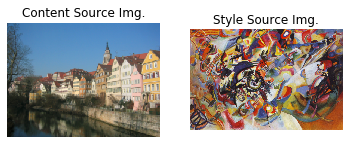

Iteration 0


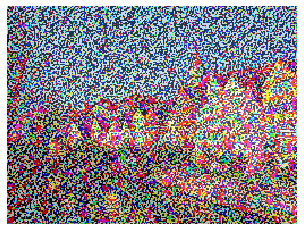

Iteration 100


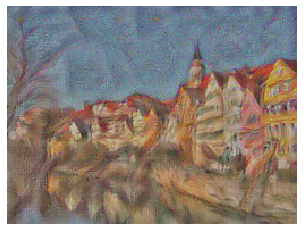

Iteration 199


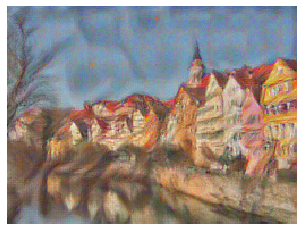

In [ ]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

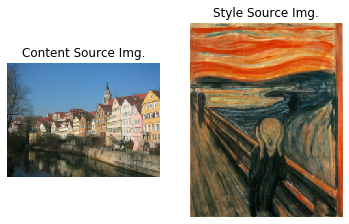

Iteration 0


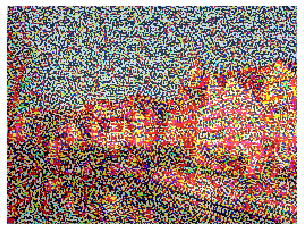

Iteration 100


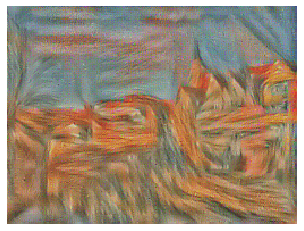

Iteration 199


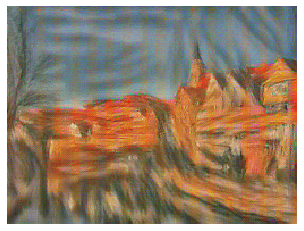

In [ ]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

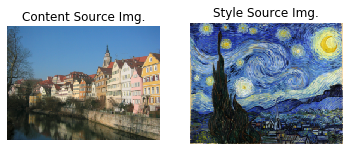

Iteration 0


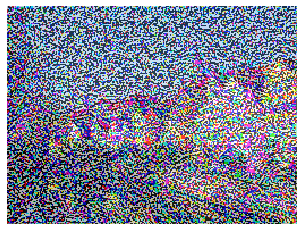

Iteration 100


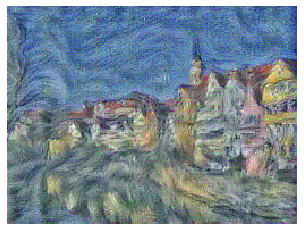

Iteration 199


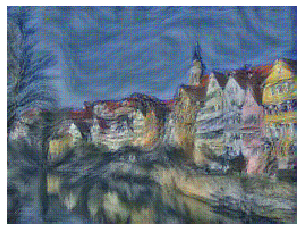

In [ ]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

## Feature Inversion



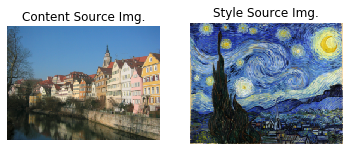

Iteration 0


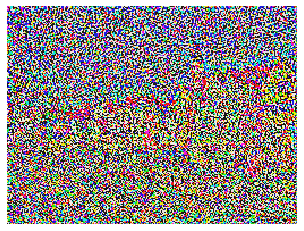

Iteration 100


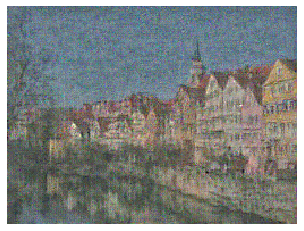

Iteration 199


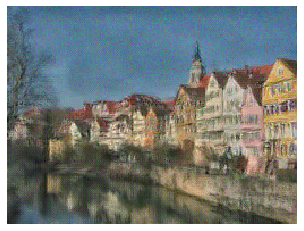

In [ ]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)